In [2]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("MLLib examples") \
    .getOrCreate()

ds = spark.read.format("libsvm").load("s3://csed516/sample_iris_data.txt")
ds.take(2)

[Row(label=1.0, features=SparseVector(4, {0: -0.5556, 1: 0.25, 2: -0.8644, 3: -0.9167})),
 Row(label=1.0, features=SparseVector(4, {0: -0.6667, 1: -0.1667, 2: -0.8644, 3: -0.9167}))]

In [2]:
from pyspark.ml.clustering import KMeans

# Train a k-means model.
kmeans = KMeans().setK(2).setSeed(1)
model = kmeans.fit(ds)

# Evaluate clustering by computing Within Set Sum of Squared Errors.
wssse = model.computeCost(ds)
print("Within Set Sum of Squared Errors = " + str(wssse))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Within Set Sum of Squared Errors = 48.574745171474284
Cluster Centers: 
[ 0.08999993 -0.27333336  0.32406773  0.31333337]
[-0.60777778  0.18166667 -0.84271174 -0.88000014]


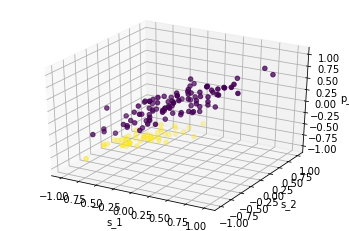

In [4]:
# visualize two clusters
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np

transformed = model.transform(ds).select("features", "prediction")

pddf = transformed.toPandas()
fv = pddf['features'].values.tolist()
fv = pd.DataFrame(np.asarray(fv))
fv.columns = ['s_1', 's_2','p_1','p_2']

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.scatter(fv['s_1'],fv['s_2'],fv['p_1'],c=pddf['prediction'])
ax.set_xlabel('s_1')
ax.set_ylabel('s_2')
ax.set_zlabel('p_1')
plt.show()


In [1]:
#Supervised learning
from pyspark.ml.classification import LogisticRegression, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#load Data
inputData = spark.read.format("libsvm").load("s3://csed516/sample_iris_data.txt")


# generate the train/test split.
(train, test) = inputData.randomSplit([0.8, 0.2])

# instantiate the base classifier.
lr = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)

# instantiate the One Vs Rest Classifier.
ovr = OneVsRest(classifier=lr)


# train the multiclass model.
ovrModel = ovr.fit(train)

In [2]:
predictions = ovrModel.transform(test)

# obtain evaluator.
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
# compute the classification error on test data.
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.0434783
